# Character recognition with transfer learning in PyTorch

This is an example of using transfer learning on a character recognition task.
We used the pretrained resnet18 architecture to predict on the EMNIST database, which achieves an accuracy of ~%82.

In [1]:
import torch
from torchvision import transforms
import torchvision
import torchvision.models as models

In [2]:
#Download the pretrained resnet18 model
resnet18 = models.resnet18(pretrained=True)



In [3]:
preprocess = torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor(),
                      
                      torchvision.transforms.Lambda(lambda x: torch.cat([x, x, x], 0)), # Transform the 1 channel imges to 3 channel
                    
                      torchvision.transforms.Lambda(lambda x: torch.transpose(x,1,2)), # Transpose the letters so that they are human readable
                      
])


In [4]:
from torchvision import datasets
ds_train = datasets.EMNIST(root='./emnist_data/', split = 'letters', train=True, transform=preprocess, download=True)
ds_test = datasets.EMNIST(root='./emnist_data/', split = 'letters', train=False, transform=preprocess, download=True)
from torch.utils.data import Dataset, DataLoader

dl_train = DataLoader(ds_train,batch_size=200,shuffle=True)
dl_test = DataLoader(ds_test,batch_size=200,shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# freeze the layers of the resnet model 
resnet2 = resnet18

for param in resnet18.parameters():
  param.requires_grad = False

In [5]:
from torch import nn, optim

# The model is fully convolutional in order to be generalized and be used in the future on 
# handwriting analysis tasks

class Transfer2(nn.Module):
    def __init__(self):
        super(Transfer2, self).__init__()
        
        self.resnet = resnet2
        self.relu = nn.ReLU()
        self.avgpool = nn.AdaptiveMaxPool2d((1,1))
        self.hidden1 = nn.Linear(128,64)
        # self.hidden2 = nn.Linear(100,64)
        self.output = nn.Linear(64,26)
        self.logsoftmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.15)
    
    def forward(self,x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.avgpool(x)
        x = x.view(-1,128)
        #x = self.dropout(x)
        x = self.relu(x)
        x = self.hidden1(x)
        # x = self.hidden2(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.logsoftmax(x)
        return x

# n_classes = 27

In [7]:
from torch import nn, optim
net = Transfer2()

# x = DataLoader(ds,batch_size=200,shuffle=True)
criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters())

#function to turn integers into one-hot vectors
def hotvecs(batch,n_classes):
  out = torch.zeros((batch.shape[0],n_classes),dtype=torch.float32)
  ids2 = torch.arange(batch.shape[0])
  out[ids2,batch] = 1.
  return out



for epoch in range(3):
  for i,(train_features,train_labels) in enumerate(dl_train):
    optimizer.zero_grad()
    out = net(train_features)
    loss = criterion(out,hotvecs(train_labels-1,26))
    loss.backward()
    optimizer.step()
    if i%100 == 0:
      print(loss,epoch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(0.0370, grad_fn=<MseLossBackward>) 0
tensor(0.0323, grad_fn=<MseLossBackward>) 0
tensor(0.0233, grad_fn=<MseLossBackward>) 0
tensor(0.0179, grad_fn=<MseLossBackward>) 0
tensor(0.0170, grad_fn=<MseLossBackward>) 0
tensor(0.0126, grad_fn=<MseLossBackward>) 0
tensor(0.0142, grad_fn=<MseLossBackward>) 0
tensor(0.0122, grad_fn=<MseLossBackward>) 1
tensor(0.0124, grad_fn=<MseLossBackward>) 1
tensor(0.0098, grad_fn=<MseLossBackward>) 1
tensor(0.0103, grad_fn=<MseLossBackward>) 1
tensor(0.0113, grad_fn=<MseLossBackward>) 1
tensor(0.0107, grad_fn=<MseLossBackward>) 1
tensor(0.0127, grad_fn=<MseLossBackward>) 1
tensor(0.0119, grad_fn=<MseLossBackward>) 2
tensor(0.0090, grad_fn=<MseLossBackward>) 2
tensor(0.0116, grad_fn=<MseLossBackward>) 2
tensor(0.0108, grad_fn=<MseLossBackward>) 2
tensor(0.0086, grad_fn=<MseLossBackward>) 2
tensor(0.0115, grad_fn=<MseLossBackward>) 2
tensor(0.0119, grad_fn=<MseLossBackward>) 2


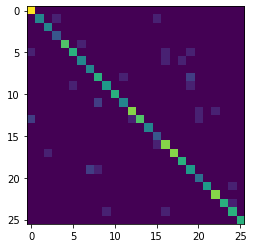

accuracy =  tensor(0.8500)


In [29]:
# validate on training data
train_features, train_labels = next(iter(dl_test))
z = net(train_features)
from sklearn.metrics import confusion_matrix

A = confusion_matrix(train_labels-1,torch.argmax(z,axis=1))

import matplotlib.pyplot as plt 

plt.imshow(A)

plt.show()

print('accuracy = ',torch.sum((train_labels-1)==torch.argmax(z,axis=1))/200)

In [30]:
right = 0
total = 0
for train_features, train_labels in dl_test:
  z = net(train_features)
  correct = torch.sum((train_labels-1)==torch.argmax(z,axis=1))
  right+=correct 
  total+=len(train_labels)

In [34]:
print('test accuracy = %.3f'%float(right/total))

test accuracy = 0.826
